<a href="https://colab.research.google.com/github/misharigot/kobe/blob/master/src/model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the neural network to predict kobe's shots.

In [4]:
import sys; sys.path.insert(0, '..')  # Needed to make the import below work

from multiple_train_test_splits import MultipleTrainTestSplits

import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from sklearn import preprocessing


import numpy as np
import csv
import pandas as pd
from scipy import stats

from keras.models import Sequential
from keras.layers import Dense
import keras
from sklearn import preprocessing
import tensorflow as ft

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [5]:
def combine_time(df: pd.DataFrame) -> pd.DataFrame:
    """Combine the minutes and seconds remaining columns into one column.
    """
    df['minutes_remaining'] = df['minutes_remaining'].astype(int)
    df['seconds_remaining'] = df['seconds_remaining'].astype(int)

    # Combine minutes and seconds remaining into decimal minutes remaining, e.g. 6.5 for 6 mins and 30 secs.
    df['time_remaining'] = round(df['minutes_remaining'] + (df['seconds_remaining'] / 60), 2)
    return df

In [6]:
def one_hot_encode(df: pd.DataFrame, encoder: preprocessing.OneHotEncoder = None) -> pd.DataFrame:
    """One-hot encode all categorical columns.
    Optionally provide an encoder. Use the training set encoder to one-hot encode the test set.
    """
     # Categorize all columns based on their data type
    categorical_columns = [
        'action_type',
        'combined_shot_type',
        'game_event_id', # Meaning?
        'game_id',
        'season',
        'shot_type',
        'shot_zone_area',
        'shot_zone_basic',
        'shot_zone_range',
        'team_id',
        'team_name',
        'matchup',
        'opponent'
    ]

    temporal_columns = [
        'game_date'
    ]

    remaining_columns = [
        'lat',
        'loc_x',
        'loc_y',
        'lon',
        'period',
        'shot_distance',
        'time_remaining',
        'shot_made_flag'  # y label
    ]

    excluded_columns = [
        'shot_id',            # Just an auto-increment id, does not mean anything
        'minutes_remaining',  # Not needed, since we use the engineered field 'time_remaining'
        'seconds_remaining'   # Not needed, since we use the engineered field 'time_remaining'
    ]

    # Convert relevant columns to categorical columns
    df[categorical_columns] = df[categorical_columns].astype('category')
    df_with_only_categoricals = df[categorical_columns]

    # One hot encode categorical columns
    if encoder is None:
        encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
        encoder.fit(df_with_only_categoricals)
    one_hot_encoded_df = pd.DataFrame(encoder.transform(df_with_only_categoricals).toarray())
    

    # Combine the one hot encoded part of the df with the remaining df
    non_categorical_df = df[remaining_columns]
    resulting_df = pd.concat([one_hot_encoded_df, non_categorical_df], axis=1)
    return resulting_df, encoder

In [7]:
def get_x(data: pd.DataFrame) -> pd.DataFrame:
    """Returns the features.
    """
    X = data.drop(columns=['shot_made_flag'])
    return X

def get_y(data: pd.DataFrame) -> pd.Series:
    """Returns the target.
    """
    Y = data['shot_made_flag'].copy()
    return Y


In [8]:
def preprocess(data: pd.DataFrame, encoder:preprocessing.OneHotEncoder = None) -> np.array:
    """Preprocess the raw kobe data from Kaggle.
    Optionally provide an encoder. Use the training set encoder to one-hot encode the test set.
    """
    df = combine_time(data)
    df, encoder = one_hot_encode(df, encoder)
    
    return df, encoder

In [15]:
mtts = MultipleTrainTestSplits(csv_path='../../data/data.csv')

test_set = mtts.test_set
loss_and_metrics = []
k_range = range(1, 26)
all_averages = []

for k in k_range:
    scores = []
    i = 0
    print()
    for train_set, validation_set in mtts.train_validation_split(as_dataframe=True):
        i += 1
        # Preprocess the training set
        preprocessed_train_set, one_hot_encoder = preprocess(train_set)
        # Split the features from the target
        x_train = get_x(preprocessed_train_set)
        y_train = get_y(preprocessed_train_set)

        # Preprocess the validation set (use the one hot encoder that was fit on the training set)
        preprocessed_validation_set, _ = preprocess(validation_set, encoder=one_hot_encoder)
        # Split the features from the target
        x_validation = get_x(preprocessed_validation_set)
        y_validation = get_y(preprocessed_validation_set)

        knn = KNeighborsClassifier(k) # We set the number of neighbors to 15
        knn.fit(x_train, y_train.astype('int'))
        y_predicted = knn.predict(x_validation)
        scores.append(accuracy_score(y_validation.astype('int'), y_predicted.astype('int')))

        print('Loop:', k, 'iteration', i, 'accuracy ', accuracy_score(y_validation.astype('int'), y_predicted.astype('int')))
    avg_accuracy = sum(scores) / len(scores)
    all_averages.append(avg_accuracy)
    print('Average per k:',avg_accuracy)


Loop: 1 iteration 1 accuracy  0.5670363884024129
Loop: 1 iteration 2 accuracy  0.5434909515469936
Loop: 1 iteration 3 accuracy  0.5380424207044172
Average per k: 0.5495232535512745

Loop: 2 iteration 1 accuracy  0.5903872348705974
Loop: 2 iteration 2 accuracy  0.5680093403385873
Loop: 2 iteration 3 accuracy  0.5610040863981319
Average per k: 0.5731335538691056

Loop: 3 iteration 1 accuracy  0.5660634364662386
Loop: 3 iteration 2 accuracy  0.5598365440747227
Loop: 3 iteration 3 accuracy  0.5471881689044561
Average per k: 0.5576960498151391

Loop: 4 iteration 1 accuracy  0.5923331387429461
Loop: 4 iteration 2 accuracy  0.572874100019459
Loop: 4 iteration 3 accuracy  0.5545826036193812
Average per k: 0.5732632807939287

Loop: 5 iteration 1 accuracy  0.5750145942790427
Loop: 5 iteration 2 accuracy  0.5672309787896478
Loop: 5 iteration 3 accuracy  0.5541934228449115
Average per k: 0.565479665304534

Loop: 6 iteration 1 accuracy  0.5968087176493482
Loop: 6 iteration 2 accuracy  0.5769604981

Text(0, 0.5, 'Testing Accuracy')

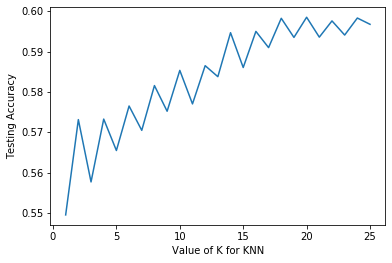

In [16]:
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(np.array(k_range), np.array(all_averages))
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [ ]:
def print_average_metrics(loss_and_metrics):
    # Get average accuracy
    accuracies = []
    for row in loss_and_metrics:
        accuracies.append(row[1])
    avg_accuracy = sum(accuracies) / len(accuracies)

    print('Average accuracy:', round(avg_accuracy, 4))


print_average_metrics(loss_and_metrics)

In [ ]:
classes = model.predict(x_validation, batch_size=128)
classes

In [ ]:
   
        
#     print('Loop:', 3 ,'accuracy ', accuracy_score(y_validation, y_predicted))
    
    # try K=1 through K=X and note the testing accuracy
#     k_range = range(1, 4)


#     for k in k_range:
        

    #plot_decision_regions(x_train[:500].to_numpy(), y_train.astype(np.integer)[:500].to_numpy(), clf=knn, feature_index = [0,1], res=0.1); # This is a slow classifier, so we reduce the resolution    

#     # allow plots to appear within the notebook
#     %matplotlib inline

#     # plot the relationship between K and testing accuracy
#     # plt.plot(x_axis, y_axis)
#     plt.plot(k_range, scores)
#     plt.xlabel('Value of K for KNN')
#     plt.ylabel('Testing Accuracy')

    #https://www.ritchieng.com/machine-learning-k-nearest-neighbors-knn/
    
    
    
    
#     input_dim = x_train.shape[1]  # number of columns (dimensions for the input layer of the model)
    
#     model = create_model(input_dim=input_dim)
#     model.fit(x_train, y_train, epochs=2, batch_size=32)

#     loss_and_metrics.append(model.evaluate(x_validation, y_validation, batch_size=128))
